# Visualization based on Philipp Arndt's tutroial

In [1]:
%matplotlib widget
import os
import ee
import geemap
import requests
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime
from datetime import timedelta
import rasterio as rio
from rasterio import plot
from rasterio import warp
import pandas as pd
from ipyleaflet import basemaps, basemap_to_tiles

from oa import dataCollector

In [2]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

In [3]:
PIG_20210127_url = 'http://openaltimetry.org/data/api/icesat2/atl08?date=2021-01-27&minx=-101.05618280606095&miny=-75.07153639057141&maxx=-100.19763809126549&maxy=-74.74493366712844&trackId=523&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json'
PIG_20210127_gtx = 'gt3r'

PIG_20201007_url = 'http://openaltimetry.org/data/api/icesat2/atl08?date=2020-10-07&minx=-101.06993207685464&miny=-75.06319452393107&maxx=-100.2946192252&maxy=-74.74165227279721&trackId=210&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json'
PIG_20201007_gtx = 'gt2r'

PIG_20201126_url = 'http://openaltimetry.org/data/api/icesat2/atl08?date=2020-11-26&minx=-101.14052925449913&miny=-75.06448446439796&maxx=-99.96378551049133&maxy=-74.71181440450334&trackId=965&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json'
PIG_20201126_gtx ='gt1l' # Check up un right beam!!

In [4]:
def plot_from_oa_url(url,gtx,title='ICESat-2 Data',plot_atl07=True,plot_atl08=True):
    mydata = dataCollector(oaurl=url,beam=gtx)
    mydata.requestData()
    myplot = mydata.plotData(title=title,plot_atl07=plot_atl07,plot_atl08=plot_atl08)
    return (myplot, mydata)

Text(0.5, 1.0, 'PIG 20210127')

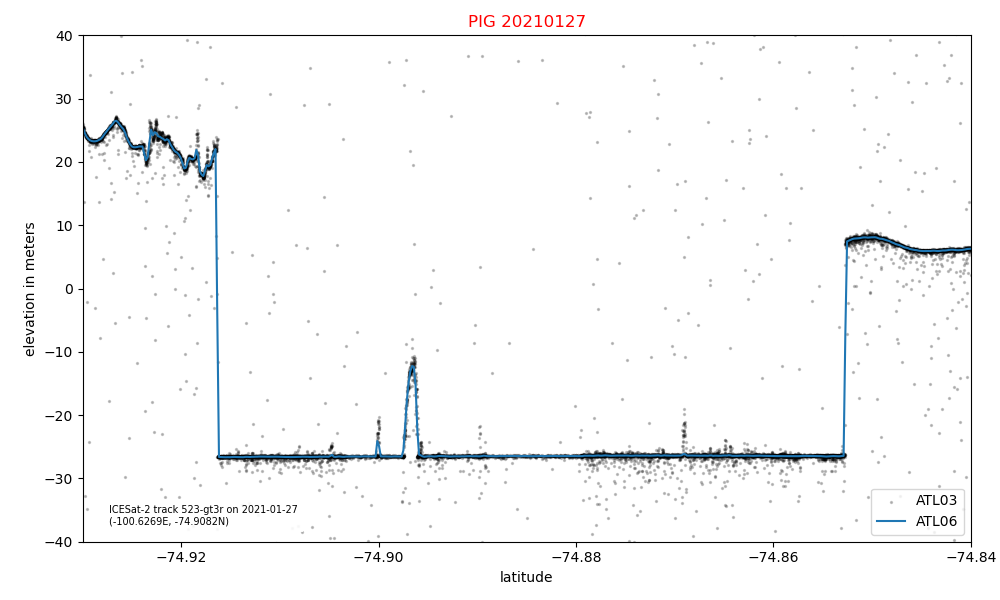

In [5]:
PIG_20210127_fig,PIG_20210127_data=plot_from_oa_url(PIG_20210127_url,PIG_20210127_gtx,title='PIG 20210127',plot_atl07=False,plot_atl08=False)
plt.xlim(-74.93,-74.84)
plt.ylim(-40,40)
plt.title('PIG 20210127',color='red')

In [6]:
figfile = 'PIG_20210127_fig.png'
PIG_20210127_fig.savefig(figfile, dpi=300)

Text(0.5, 1.0, 'PIG 20201007')

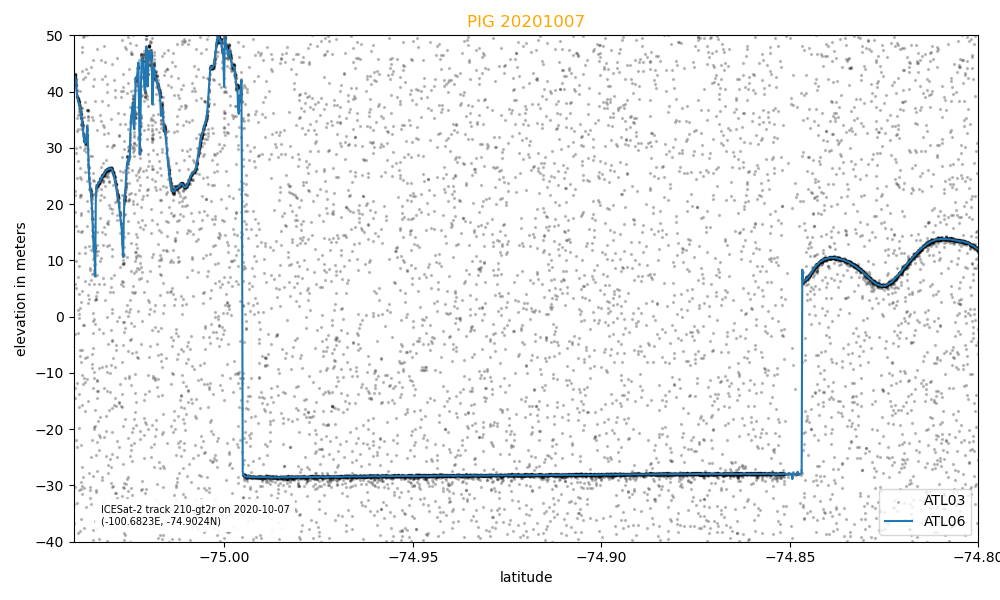

In [7]:
PIG_20201007_fig,PIG_20201007_data=plot_from_oa_url(PIG_20201007_url,PIG_20201007_gtx,title='PIG 20201007',plot_atl07=False,plot_atl08=False)
plt.xlim(-75.04,-74.8)
plt.ylim(-40,50)
plt.title('PIG 20201007',color='orange')

In [8]:
figfile = 'PIG_20201007_fig.png'
PIG_20201007_fig.savefig(figfile, dpi=300)

(-30.0, 30.0)

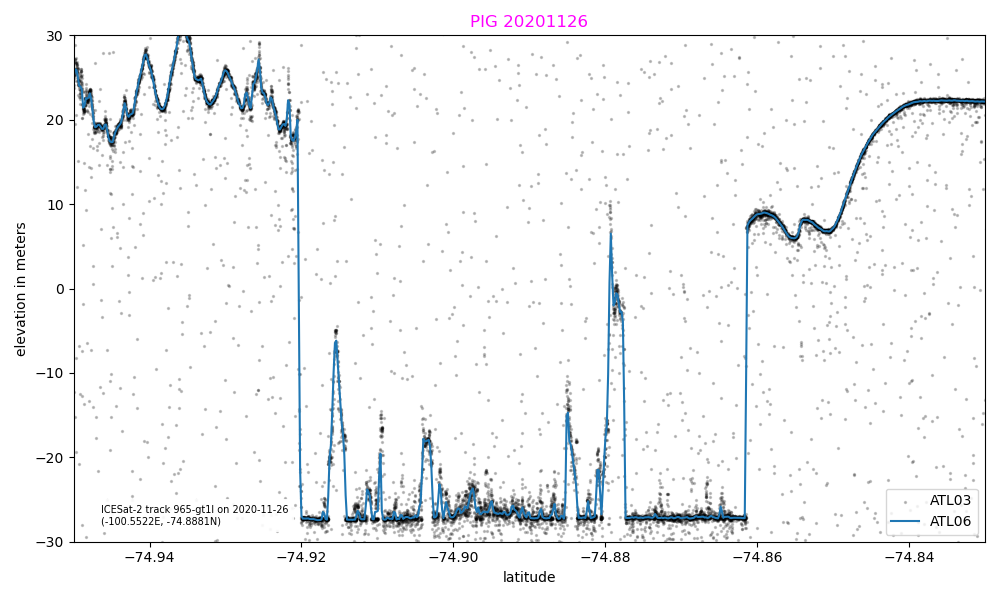

In [9]:
PIG_20201126_fig,PIG_20201126_data=plot_from_oa_url(PIG_20201126_url,PIG_20201126_gtx,title='PIG 20201126',plot_atl07=False,plot_atl08=False)
plt.title('PIG 20201126',color='magenta')
plt.xlim(-74.95,-74.83)
plt.ylim(-30,30)

In [10]:
figfile = 'PIG_20201126_fig.png'
PIG_20201126_fig.savefig(figfile, dpi=300)

## Now let's see where this IS-2 track is located

In [11]:
Map = geemap.Map()
Map


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [12]:
lat1, lat2 = PIG_20210127_data.atl08.lat[0], PIG_20210127_data.atl08.lat.iloc[-1]
lon1, lon2 = PIG_20210127_data.atl08.lon[0], PIG_20210127_data.atl08.lon.iloc[-1]
center_lon = (lon1 + lon2) / 2
center_lat = (lat1 + lat2) / 2
Map.setCenter(center_lon, center_lat, zoom=8);
Map.add_basemap('SATELLITE')

In [13]:
def is2_featurecollection(data):
    ground_track_coordinates = list(zip(data.atl08.lon, data.atl08.lat))
    ground_track_projection = 'EPSG:4326' 
    gtx_feature = ee.FeatureCollection(ee.Geometry.LineString(coords=ground_track_coordinates, 
                                      proj=ground_track_projection, 
                                      geodesic=True))
    return gtx_feature


PIG_20210127_feature = is2_featurecollection(PIG_20210127_data)
PIG_20201007_feature = is2_featurecollection(PIG_20201007_data)
PIG_20201126_feature = is2_featurecollection(PIG_20201126_data)
    

In [14]:
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    
    #Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask).divide(10000)

# def divideS2(image):
#     return image.divide(10000)

def getMatchingS2Image(data,center_lon,center_lat,mask_clouds=True):
    s2 = ee.ImageCollection('COPERNICUS/S2_SR')
    POI = ee.Geometry.Point(center_lon, center_lat)
    s2 = s2.filterBounds(POI)
    
    days_buffer_imagery = 30

    dateformat = '%Y-%m-%d'
    datetime_requested = datetime.strptime(data.date, dateformat)
    search_start = (datetime_requested - timedelta(days=days_buffer_imagery)).strftime(dateformat)
    search_end = (datetime_requested + timedelta(days=days_buffer_imagery)).strftime(dateformat)

    s2 = s2.filterDate(search_start, search_end)
    # s2 = s2.map(divideS2)
    s2 = s2.filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',60)
    if mask_clouds == True:
        s2 = s2.map(maskS2clouds)
    return s2.median()

In [15]:
PIG_20210127_s2Image = getMatchingS2Image(PIG_20210127_data,center_lon,center_lat,mask_clouds=True)
PIG_20201007_s2Image = getMatchingS2Image(PIG_20201007_data,center_lon,center_lat,mask_clouds=True)
PIG_20201126_s2Image = getMatchingS2Image(PIG_20201126_data,center_lon,center_lat,mask_clouds=True)

In [16]:
s2Vis = {
  'min': 0.4,
  'max': 1,
  # 'gamma': 1.4,
  'bands': ['B4', 'B3', 'B2'],
};

Map.addLayer(PIG_20210127_s2Image,s2Vis,'PIG_20210127_s2Image')
Map.addLayer(PIG_20201007_s2Image,s2Vis,'PIG_20201007_s2Image')
Map.addLayer(PIG_20201126_s2Image,s2Vis,'PIG_20201126_s2Image')

In [17]:
bmr_alongflow = ee.Image('users/azcryosphere/SheanPIG_BMR_along-flow')
bmr_initialpixel = ee.Image('users/azcryosphere/SheanPIG_BMR_initial-pixel')

meltVis = {'min':0, 'max': 60, 'palette':['black','darkmagenta','red','orange','yellow','white']}

Map.addLayer(bmr_alongflow, meltVis,'Shean et al. 2019 - along flow BMR')
Map.addLayer(bmr_initialpixel, meltVis,'Shean et al. 2019 - initial pixel BMR')

colors = meltVis['palette']
vmin = meltVis['min']
vmax = meltVis['max']

Map.add_colorbar_branca(colors=colors, vmin=vmin, vmax=vmax, layer_name="Shean et al. 2019 - initial pixel BMR")

In [18]:
Map.addLayer(PIG_20210127_feature,{'color':'red'},'PIG_20210127_feature')
Map.addLayer(PIG_20201007_feature,{'color':'orange'},'PIG_20201007_feature')
Map.addLayer(PIG_20201126_feature,{'color':'magenta'},'PIG_20201126_feature')

## Now we move on to Bach

In [19]:
Bach_20181226_url = 'http://openaltimetry.org/data/api/icesat2/atl08?date=2018-12-26&minx=-72.93860124512382&miny=-72.31989573957638&maxx=-72.60900185631486&maxy=-72.19542641765992&trackId=1352&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&outputFormat=json'
Bach_20181226_gtx = 'gt3l'

Bach_20191224_url = 'http://openaltimetry.org/data/api/icesat2/atl08?date=2019-12-24&minx=-72.93860124512382&miny=-72.31989573957638&maxx=-72.60900185631486&maxy=-72.19542641765992&trackId=1352&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&outputFormat=json'
Bach_20191224_gtx = 'gt3l'

Bach_20211220_url = 'http://openaltimetry.org/data/api/icesat2/atl08?date=2021-12-20&minx=-72.93860124512382&miny=-72.31989573957638&maxx=-72.60900185631486&maxy=-72.19542641765992&trackId=1352&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&outputFormat=json'
Bach_20211220_gtx = 'gt3l'

Text(0.5, 1.0, 'Bach 20181226')

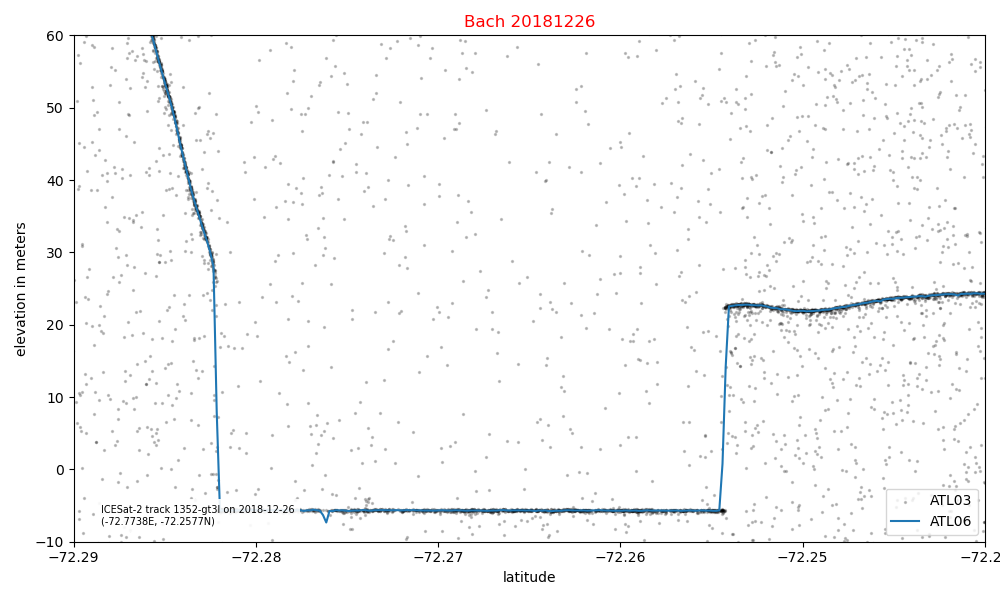

In [20]:
Bach_20181226_fig,Bach_20181226_data=plot_from_oa_url(Bach_20181226_url,Bach_20181226_gtx,title='Bach 20181226',plot_atl07=False,plot_atl08=False)
plt.xlim(-72.29,-72.24)
plt.ylim(-10,60)
plt.title('Bach 20181226',color='red')

In [21]:
figfile = 'Bach_20181226_fig.png'
plt.savefig(figfile, dpi=300)

Text(0.5, 1.0, 'Bach 20191224')

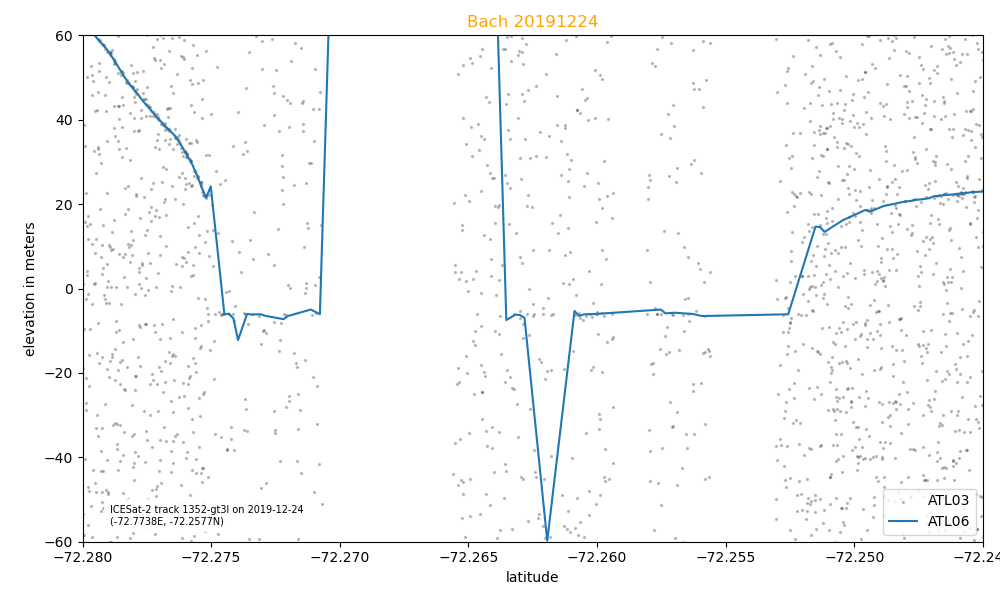

In [22]:
Bach_20191224_fig,Bach_20191224_data=plot_from_oa_url(Bach_20191224_url,Bach_20191224_gtx,title='Bach 20191224',plot_atl07=False,plot_atl08=False)
plt.xlim(-72.28,-72.245)
plt.ylim(-60,60)
plt.title('Bach 20191224',color='orange')

In [23]:
figfile = 'Bach_20191224_fig.png'
plt.savefig(figfile, dpi=300)

Text(0.5, 1.0, 'Bach 20211220')

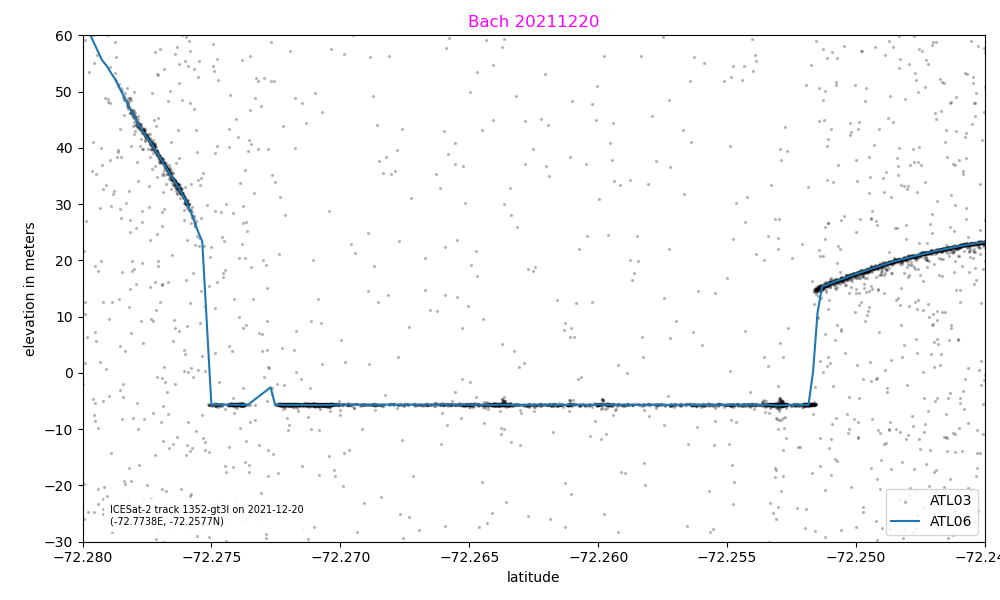

In [24]:
Bach_20211220_fig,Bach_20211220_data=plot_from_oa_url(Bach_20211220_url,Bach_20211220_gtx,title='Bach 20211220',plot_atl07=False,plot_atl08=False)
plt.xlim(-72.28,-72.245)
plt.ylim(-30,60)
plt.title('Bach 20211220',color='magenta')

In [25]:
figfile = 'Bach_20211220_fig.png'
plt.savefig(figfile, dpi=300)

In [26]:
MapBach = geemap.Map()
MapBach

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [27]:
lat1Bach, lat2Bach = Bach_20181226_data.atl08.lat[0], Bach_20181226_data.atl08.lat.iloc[-1]
lon1Bach, lon2Bach = Bach_20181226_data.atl08.lon[0], Bach_20181226_data.atl08.lon.iloc[-1]
center_lonBach = (lon1Bach + lon2Bach) / 2
center_latBach = (lat1Bach + lat2Bach) / 2
MapBach.setCenter(center_lonBach, center_latBach, zoom=10);
MapBach.add_basemap('SATELLITE')

In [28]:
Bach_20181226_feature = is2_featurecollection(Bach_20181226_data)
Bach_20191224_feature = is2_featurecollection(Bach_20191224_data)
Bach_20211220_feature = is2_featurecollection(Bach_20211220_data)

In [29]:
Bach_20181226_s2Image = getMatchingS2Image(Bach_20181226_data,center_lonBach,center_latBach,mask_clouds=False).divide(10000)
Bach_20191224_s2Image = getMatchingS2Image(Bach_20191224_data,center_lonBach,center_latBach,mask_clouds=False).divide(10000)
Bach_20211220_s2Image = getMatchingS2Image(Bach_20211220_data,center_lonBach,center_latBach,mask_clouds=False).divide(10000)

In [30]:
MapBach.addLayer(Bach_20181226_s2Image,s2Vis,'Bach_20181226_s2Image')
MapBach.addLayer(Bach_20191224_s2Image,s2Vis,'Bach_20191224_s2Image')
MapBach.addLayer(Bach_20211220_s2Image,s2Vis,'Bach_20211220_s2Image')

In [31]:
MapBach.addLayer(Bach_20181226_feature,{'color':'red'},'Bach_20181226_feature')
MapBach.addLayer(Bach_20191224_feature,{'color':'orange'},'Bach_20191224_feature')
MapBach.addLayer(Bach_20211220_feature,{'color':'magenta'},'Bach_20211220_feature')